In [1]:
# import modules
import csv
import numpy as np
import random

from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
from ast import literal_eval


# UCSD Data

In [2]:
# import cleaned fluency data
# original data (before cleaning) downloaded from https://osf.io/j6qea/ (Zemla & Austerweil, 2019)
all_ucsd_lists_table = pd.read_csv("ucsd_fluency_cleaned.csv", 
    converters={'item': eval})
all_ucsd_lists_table.head()

,id,listnum,group,SEX,EDUC,DRS,MMSE,category,rank,item
0,5,4,NC,2,16,144,30,animals,1.0,"[armadillo, horse, cow, goat, pig, rabbit, mou..."
1,6,4,NC,1,19,144,30,animals,1.0,"[mouse, rat, raccoon, dog, cat, elephant, cow,..."
2,93,1,NC,2,14,143,30,animals,1.0,"[dog, cat, ape, elephant, monkey, chimpanzee, ..."
3,93,2,NC,2,14,138,26,animals,1.0,"[owl, rhinoceros, buffalo, horse, dog, cat, el..."
4,93,3,NC,2,14,143,30,animals,1.0,"[dog, rat, camel, horse, cat, ferret, hamster,..."


In [3]:
# check how many items are not in animal category
# animals list adapted from https://gist.github.com/atduskgreg/3cf8ef48cb0d29cf151bedad81553a54#file-animals-txt

with open('animals_list.txt', 'r') as f:
    animal_list = [line.strip() for line in f] 
animal_list_lowercase = [str.lower(a) for a in animal_list]

not_in_animal_list = []
for i in range(len(all_ucsd_lists_table)):
    list_i=all_ucsd_lists_table.iloc[i][-1] 
    for animal_j in list_i:
        if animal_j not in animal_list_lowercase:
            not_in_animal_list += [animal_j]
print('check if you have the most updated table and animals list: ', len(not_in_animal_list)==190)


check if you have the most updated table and animals list:  True


In [4]:
# tables split by diagnosis
NC_table = all_ucsd_lists_table.loc[
    all_ucsd_lists_table['group'] == 'NC']
ProbAD_table = all_ucsd_lists_table.loc[
    all_ucsd_lists_table['group'] == 'ProbAD']

# IDs split by diagnosis
NC_ids = list(set(list(NC_table['id'])))
ProbAD_ids = list(set(list(ProbAD_table['id'])))

#Combined IDs:
NC_and_ProbAD_ids = [i for i in NC_ids if i in ProbAD_ids]


# Plotting functions

In [5]:
# basic dot plot fxns 

def delta(x,y):
    return 1 if x == y and x!= 'nan' and y!='nan' else 0

def M(seq1,seq2,i,j,k):
    return sum(delta(x,y) for x,y in zip(seq1[i:i+k],seq2[j:j+k]))

def makeMatrix(seq1,seq2,k):
    n = len(seq1)
    m = len(seq2)
    return [[M(seq1,seq2,i,j,k) for j in range(m-k+1)] for i in range(n-k+1)]

In [6]:
def simple_dotplot(seqx, seqy, filename_str="test.png"):
    dotplot =  np.array(makeMatrix([i for i in seqy if i!='nan'],[i for i in seqx if i!='nan'],1))

    plt.imshow(dotplot, cmap='Blues')
    
    plt.xlabel('List 1')
    plt.ylabel('List 2')
    
    plt.xticks(np.arange(len(seqx)), seqx, rotation=90)
    plt.yticks(np.arange(len(seqy)), seqy)
    ax=plt.gca()                            # get the axis
    ax.xaxis.tick_top()                     # and move the X-Axis      
    ax.xaxis.set_label_position('top') 

    #plt.savefig(filename_str)    # <-- uncomment to save image
    plt.show()



In [7]:
def individual_dotplot(subjID, seqx,diag_x,listnum_x, seqy,diag_y,listnum_y, filename_str="test.png"):
    """
    generates individual-level dotplots with semantic fluency features
    """

    noblanks_x = [i for i in seqx if i!='nan']
    noblanks_y = [i for i in seqy if i!='nan']
    
    new_dotplot = np.array(makeMatrix(noblanks_y,noblanks_x,1))
    x_labels = noblanks_x
    y_labels = noblanks_y
    
    fig, ax=plt.subplots()
    plt.grid(color='lightgrey', linestyle='-', linewidth=.1)
    plt.imshow(new_dotplot, cmap = 'Blues')
    ax.set_axisbelow(True)
    
    # to plot missing on axis: 
    
    paired_seqs = [noblanks_x, noblanks_y]
    seqx_p,seqy_p=paired_seqs
    in1_not2 = list(set(seqx_p)-set(seqy_p))
    in2_not1 = list(set(seqy_p)-set(seqx_p))

    x_pts =[]
    enum_x = enumerate(noblanks_x)
    enum_x_list = list(enum_x)
    for j in range(len(enum_x_list)):
        for missing in in1_not2:
            if enum_x_list[j][1]==missing:
                x_pts += [enum_x_list[j][0]]
    x_axis_points = x_pts
    
    y_pts =[]
    enum_y = enumerate(noblanks_y)
    enum_y_list = list(enum_y)
    for k in range(len(enum_y_list)):
        for missing in in2_not1:
            if enum_y_list[k][1]==missing:
                y_pts += [enum_y_list[k][0]]
    y_axis_points = y_pts
    
    plt.plot(x_axis_points+[-1 for i in range(len(y_axis_points))], 
             [-1 for i in range(len(x_axis_points))]+y_axis_points,
             's', color = 'orange')

    # marking repeats:
    
    x_tick_repeats = [i for i, x in enumerate(noblanks_x) if noblanks_x.count(x) > 1]
    y_tick_repeats = [i for i, y in enumerate(noblanks_y) if noblanks_y.count(y) > 1]
    x_coords_reps = []
    y_coords_reps = []
    if x_tick_repeats != []:
        for idx in x_tick_repeats:
            if noblanks_x[idx] in noblanks_y:
                x_coords_reps += [idx]
                y_coords_reps_list = [i for i, y in enumerate(noblanks_y) if y==noblanks_x[idx]]
                y_coords_reps += [y_coords_reps_list[0]]
                
                y_coords_reps_list = y_coords_reps_list[1:]
                while y_coords_reps_list!=[]:
                    x_coords_reps += [idx]
                    y_coords_reps += [y_coords_reps_list[0]]
                    y_coords_reps_list = y_coords_reps_list[1:]
            else:
                x_coords_reps += [idx]
                y_coords_reps += [-1]

    if y_tick_repeats != []:
        for idx in y_tick_repeats:
            if noblanks_y[idx] in noblanks_x:
                y_coords_reps += [idx]
                x_coords_reps_list = [i for i, x in enumerate(noblanks_x) if x==noblanks_y[idx]]
                x_coords_reps += [x_coords_reps_list[0]]
                
                x_coords_reps_list = x_coords_reps_list[1:]
                while x_coords_reps_list!=[]:
                    y_coords_reps += [idx]
                    x_coords_reps += [x_coords_reps_list[0]]
                    x_coords_reps_list = x_coords_reps_list[1:]
            else:
                y_coords_reps += [idx]
                x_coords_reps += [-1]
    plt.plot(x_coords_reps, y_coords_reps,
             '>', color = 'lightgreen', markeredgewidth=1, markeredgecolor='xkcd:irish green')
            
    #showing invalid entries:
    def find_non_animals(list_1):
        with open('animals_list.txt', 'r') as f:
            animal_list = [line.strip() for line in f]
        animal_list_lowercase = [str.lower(a) for a in animal_list]

        not_in_animal_list = []
        
        for animal_j in list_1:
            if animal_j not in animal_list_lowercase:
                not_in_animal_list += [animal_j]
        return not_in_animal_list
        
    not_in_list = find_non_animals(noblanks_x) + find_non_animals(noblanks_y)
    invalids = not_in_list
    
    x_tick_invalids = [i for i, x in enumerate(noblanks_x) if x in invalids]
    y_tick_invalids = [i for i, x in enumerate(noblanks_y) if x in invalids]
    
    if x_tick_invalids != []:
        for idx in x_tick_invalids:
            x_labels[idx]=x_labels[idx]+'*'
        plt.plot(x_tick_invalids, [-1 for i in range(len(x_tick_invalids))],
             'x', color = 'red', markeredgewidth=2, markeredgecolor='xkcd:deep red')  
    if y_tick_invalids != []:
        for idx in y_tick_invalids:
            y_labels[idx]=y_labels[idx]+'*'
        plt.plot([-1 for i in range(len(y_tick_invalids))], y_tick_invalids,
             'x', color = 'red', markeredgewidth=2, markeredgecolor='xkcd:deep red')           
      
    numbered_x_labels = x_labels
    numbered_y_labels = y_labels
    numbered_x_labels = [str(i+1)+'. '+x for i,x in enumerate(x_labels)]
    numbered_y_labels = [str(i+1)+'. '+y for i,y in enumerate(y_labels)]
    
    plt.xticks(np.arange(len(x_labels)), numbered_x_labels, rotation=90, fontsize=8)
    plt.yticks(np.arange(len(y_labels)), numbered_y_labels, fontsize=8)
    plt.title('SubjID:  {0}'.format(subjID))
    plt.xlabel('L1: {0}, List {1}'.format(diag_x,listnum_x))
    plt.ylabel('L2: {0}, List {1}'.format(diag_y,listnum_y))
    
    
    #coloring repeats' labels:
    if x_tick_repeats != []:
        for idx in x_tick_repeats:
            ax.get_xticklabels()[idx].set_color("g")
    if y_tick_repeats != []:
        for idx in y_tick_repeats:
            ax.get_yticklabels()[idx].set_color("g")
    
    lgd = ax.legend(('forgotten items', 'repeated items', 'out-of-category items'),
           bbox_to_anchor=(1.03,1), loc="upper left")
    
    
    ax=plt.gca()                            # get the axis
    ax.xaxis.tick_top()                     # and move the X-Axis      
    ax.xaxis.set_label_position('top')   
    
    plt.tight_layout()        
    #plt.savefig(filename_str, dpi=800)   # <-- uncomment to save image
    
    plt.show()
    

In [8]:
def group_dotplot_scaling(size, full_table, ids, condition):
    cumulative_allpairs = np.zeros([size,size])
    num_pairs = 0

    for ID in ids:
        id_table = full_table.loc[full_table['id'] == ID]
        if len(condition)>1:
            cond_table = id_table[id_table['group'].isin(condition)]
        else:
            cond = condition[0]
            cond_table = id_table.loc[id_table['group']==cond]
        
        for i in range(len(cond_table)):
            if i < len(cond_table)-1:
                id_i = cond_table.iloc[i]['id']
                id_next = cond_table.iloc[i+1]['id']

                seqx = cond_table.iloc[i][-1].copy()
                seqy = cond_table.iloc[i+1][-1].copy()

                if len(seqx)<=size:
                    seqx += [np.nan for i in range(size-len(seqx))]
                else:
                    seqx = seqx[0:size]

                if len(seqy)<=size:
                    seqy += [np.nan for i in range(size-len(seqy))]
                else:
                    seqy = seqy[0:size]  

                if id_i == id_next:
                    dotplot = np.array(makeMatrix(seqy,seqx,1))
                    cumulative_allpairs += dotplot
                    num_pairs += 1
    
    cumulative_allpairs_scaled = cumulative_allpairs/num_pairs
    return cumulative_allpairs_scaled, num_pairs

# Example plots

## Fig 1: basic features

In [9]:
listA1 = ['word A','word B','word C','word D','word E']
listB1 = ['word A','word C','word B','word E','word D']
listC1 = ['word A','word C','word D','word B','word F', 'word G']

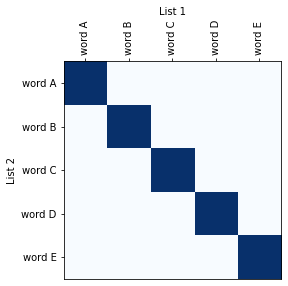

In [10]:
simple_dotplot(listA1,listA1,"test1-nolabel.pdf") 

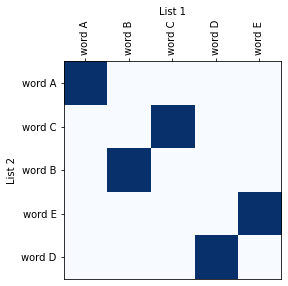

In [11]:
simple_dotplot(listA1,listB1,"test2-nolabel.pdf") 

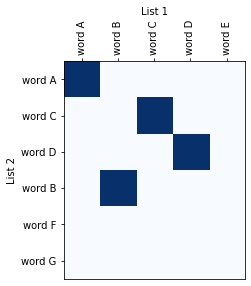

In [12]:
simple_dotplot(listA1,listC1,"test3-nolabel.pdf") 

## Fig 2: semantic fluency example, individual-level plots

In [13]:
list1 = ['camel','elephant','giraffe','monkey','gorilla','seal','parakeet','cockatiel',
         'cockatoo','crow','hawk','donkey','lion','tiger','stork','duck','goose','panda']
list2 = ['lion','tiger','monkey','ball','elephant','dog','cat','camel','snake','mouse',
         'dog','monkey','giraffe','fish','cow','horse','sheep','goat']

listA01 = ['cat','dog','sheep','monkey','seal',
          'duck', 'giraffe','elephant','tiger', 'cobra']
listA02 = ['cat','dog','pig','cow','goat', 'giraffe','monkey','zebra',
           'lion', 'tiger', 'elephant','seal','shark','dolphin','fish', 'cobra']
listA03 = ['cat','dog','cow','sheep','mouse', 'seal','dolphin','pig',
           'giraffe', 'elephant', 'gorilla','snake','panther',
           'bear','cheetah', 'antelope']
listA04 = ['dog','cat','duck','mouse','elephant',
          'giraffe', 'zebra','stork','dolphin']     

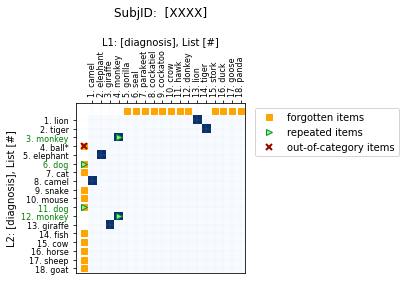

In [14]:
individual_dotplot('[XXXX]\n',  list1,'[diagnosis]','[#]', list2,'[diagnosis]','[#]', "new_dotplot_2821_lg-1.pdf") 


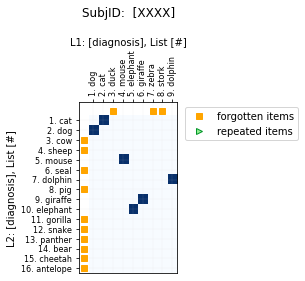

In [15]:
individual_dotplot('[XXXX]\n',  listA04,'[diagnosis]','[#]', listA03,'[diagnosis]','[#]', "new_dotplot_fig4b-new.pdf") 


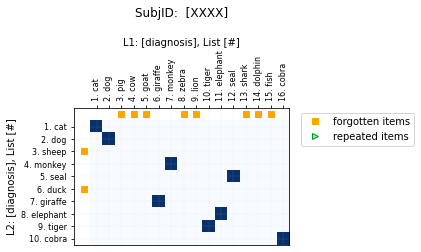

In [16]:
individual_dotplot('[XXXX]\n',  listA02,'[diagnosis]','[#]', listA01,'[diagnosis]','[#]', "new_dotplot_fig4a-new.pdf") 


## Fig 4: group-level plots

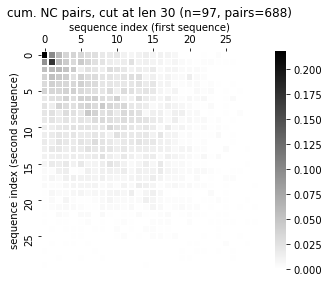

In [17]:
NCs_30_scaledNP, num_lists_NCs_30 = group_dotplot_scaling(30, all_ucsd_lists_table, NC_ids, ['NC'])
ax = sns.heatmap(NCs_30_scaledNP, cmap='binary', linewidth=0.5, xticklabels = 5, yticklabels = 5)
plt.title('cum. NC pairs, cut at len 30 (n={0}, pairs={1})'.format(len(NC_ids),
                                                            num_lists_NCs_30))
plt.xlabel('sequence index (first sequence)')
plt.ylabel('sequence index (second sequence)')

plt.gca().set_aspect('equal', adjustable='box')
ax.xaxis.tick_top()   #  move the X-Axis      
ax.xaxis.set_label_position('top') 
#plt.savefig("NC.pdf")

plt.show()


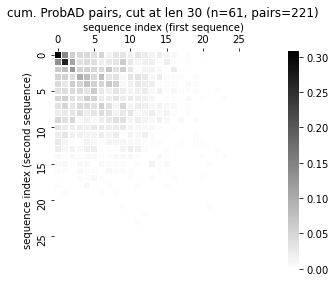

In [18]:
ProbADs_30_scaledNP,num_lists_ProbADs_30 = group_dotplot_scaling(30, all_ucsd_lists_table, 
                                                       ProbAD_ids, ['ProbAD'])
ax = sns.heatmap(ProbADs_30_scaledNP, cmap='binary', linewidth=0.5, xticklabels = 5, yticklabels = 5)
plt.title('cum. ProbAD pairs, cut at len 30 (n={0}, pairs={1})'.format(len(ProbAD_ids),
                                                                num_lists_ProbADs_30))
plt.xlabel('sequence index (first sequence)')
plt.ylabel('sequence index (second sequence)')

plt.gca().set_aspect('equal', adjustable='box')
ax.xaxis.tick_top()  #  move the X-Axis      
ax.xaxis.set_label_position('top') 
#plt.savefig("probAD.pdf")

plt.show()


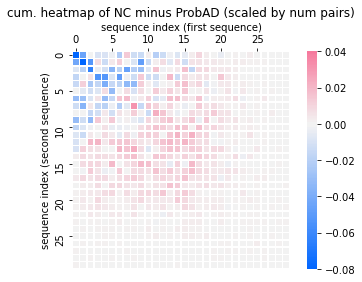

In [19]:
subtracted = NCs_30_scaledNP-ProbADs_30_scaledNP
clrmap = sns.diverging_palette(255, 1, as_cmap=True, sep=4, l=45, s=160)
ax = sns.heatmap(subtracted, cmap=clrmap,vmin=-.08, vmax=.04, linewidth=0.5, center=0, xticklabels = 5, yticklabels = 5)

plt.gca().set_aspect('equal', adjustable='box')
ax.xaxis.tick_top()  #  move the X-Axis      
ax.xaxis.set_label_position('top') 

plt.title('cum. heatmap of NC minus ProbAD (scaled by num pairs)')
plt.xlabel('sequence index (first sequence)')
plt.ylabel('sequence index (second sequence)')

#plt.savefig("ncprobad.pdf")
plt.show()
